In [1]:
import pandas as pd
import os
import glob

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
import rasterio

In [3]:
import pprint

In [4]:
#pprint.pprint(os.listdir('../logs/experiments/runs/'))

In [5]:
expname = 'topview_streetview_04-26_A'

# TODO for topview_swin_04-19_C take test predictions from the runs that were trained on this country
# Same for topview_swin_04-19_D and streetview_swin_04-19_C

In [6]:
expdir = f'../logs/experiments/runs/{expname}/'
os.listdir(expdir)

['2024-04-26_08-28-34', '2024-04-26_08-28-59']

In [7]:
all_logdirs = [os.path.join(expdir, dd) for dd in os.listdir(expdir)]

In [8]:
logdirs = []
folds = []

fold_key = None

for fold in range(20):
    for logdir in all_logdirs:
        if os.path.exists(os.path.join(logdir, f'test_predictions_fold_{fold}.csv')):
            print(fold, logdir)
            logdirs.append(logdir)
            folds.append(fold)
            
            with open(os.path.join(logdir, 'config_tree.log')) as f:
                config_tree = f.readlines()

0 ../logs/experiments/runs/topview_streetview_04-26_A/2024-04-26_08-28-34
1 ../logs/experiments/runs/topview_streetview_04-26_A/2024-04-26_08-28-34
2 ../logs/experiments/runs/topview_streetview_04-26_A/2024-04-26_08-28-34
3 ../logs/experiments/runs/topview_streetview_04-26_A/2024-04-26_08-28-59
4 ../logs/experiments/runs/topview_streetview_04-26_A/2024-04-26_08-28-59


In [9]:
config_tree

['CONFIG\n',
 '├── datamodule\n',
 '│   └── _target_: ai4eo_mapyourcity.datamodules.mapyourcity_datamodule.MapYourCi\n',
 '│       batch_size: 32                                                          \n',
 '│       num_workers: 8                                                          \n',
 '│       pin_memory: false                                                       \n',
 '│       dataset_options:                                                        \n',
 '│         data_dir: /work/ka1176/caroline/gitlab/AI4EO-MapYourCity/scripts/../da\n',
 '│         fold: 4                                                               \n',
 '│         fold_dir: /work/ka1176/caroline/gitlab/AI4EO-MapYourCity/scripts/../da\n',
 '│         fold_key: random_stratified_labels_cities                             \n',
 '│         model_id: swinv2_tiny_window16_256.ms_in1k                            \n',
 '│         img_file: overwrite.jpg                                               \n',
 '│      

In [10]:
for l in config_tree:
    if 'fold_key' in l:
        fold_key = l.strip().split(' ')[-1]
        break
print(fold_key)

random_stratified_labels_cities


In [11]:
all_test_df = []
all_valid_df = []

all_pids = []

for fold, logdir in zip(folds, logdirs):
    rnd = {'predicted_labels':'predicted_label'}
    
    tt = pd.read_csv(os.path.join(logdir, f'test_predictions_fold_{fold}.csv')).rename(columns=rnd)
    vv = pd.read_csv(os.path.join(logdir, f'valid_predictions_fold_{fold}.csv')).rename(columns=rnd) 
    dd = pd.read_csv(f'../data/AI4EO-MapYourCity/splits/{fold_key}/split_valid_{fold}.csv')  
    
    tt['fold'] = fold
    vv['fold'] = fold
    
    all_pids.append(tt['pid'].sort_values().values)
    
    print(len(tt['pid']))
    all_test_df.append(tt)
    all_valid_df.append(pd.merge(vv, dd, on='pid'))

4529
4529
4529
4529
4529


In [12]:
test_df = pd.concat(all_test_df)
test_df['predicted_label'] = test_df['predicted_label'].astype(int)
test_df.pivot_table(index=['pid', 'fold'])

predicted_label
pid        fold                 
22mhjewvtj 0                 4.0
           1                 4.0
           2                 4.0
           3                 3.0
           4                 5.0
...                          ...
zzvxsygznl 0                 0.0
           1                 0.0
           2                 0.0
           3                 0.0
           4                 0.0

[22645 rows x 1 columns]

In [13]:
test_df.assign(experiment=expname).to_csv(f'../submissions/all_folds/{expname}.csv', index=False)

In [14]:
def get_best_class(sdf):
    '''
    Return the majority vote
    If tied, choose class closest to the mean
    
    '''
    
    spids = []
    slbls = []
    # mode did not work with groupby
    for pid in test_df['pid'].unique():
        dd = test_df.loc[test_df['pid'] == pid]
        mode = dd['predicted_label'].mode()
        mean = dd['predicted_label'].mean()
                
        if len(mode) > 1:
            mode = mode.iloc[np.argmin(np.abs(mode-mean))]
        else:
            mode = mode.values[0]
            
        spids.append(pid)
        slbls.append(mode)
                
    return pd.DataFrame(dict(pid=spids, predicted_label=slbls)).sort_values('pid')

In [15]:
submission_df = get_best_class(test_df)

In [16]:
submission_df.to_csv(f'../submissions/{expname}.csv', index=False)
submission_df.head()

,pid,predicted_label
3997,22mhjewvtj,4
2557,22pujdqtiu,6
1770,23ykackznc,0
3119,2435ikdnmf,1
1491,24akvvheae,0


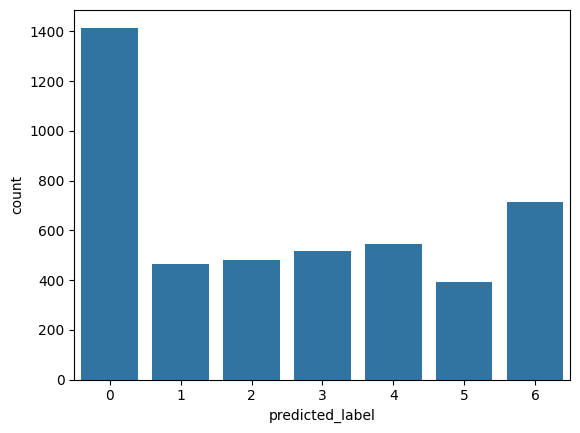

In [17]:
sns.barplot(submission_df['predicted_label'].value_counts());

In [18]:
reference_submissions = ['streetview_swinv2_trafo.csv',
                         'topview_swinv2_trafo.csv',
                         'merged_topstreet_swin_04-16_C.csv',
                         'topview_street_sentinel2_04-23_B.csv',
                         f'{expname}.csv',
                        ]

In [19]:
all_submissions = pd.concat([pd.read_csv(os.path.join('../submissions/', f))['predicted_label'].value_counts().to_frame().assign(source=f) \
                             for f in reference_submissions])

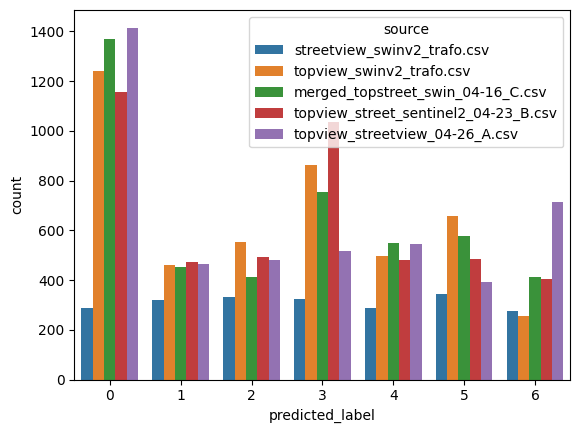

In [20]:
sns.barplot(all_submissions, x='predicted_label', y='count', hue='source');

In [21]:
assert test_df['pid'].value_counts().std() == 0 # all pids in all folds

In [22]:
valid_df = pd.concat(all_valid_df)
valid_df.head()

,pid,predicted_label,fold_x,label,country_id,city_id,fold_y
0,fyjdaa7aty,1,0,0,PNN,U8MZD,0
1,ksl4brajis,4,0,0,PNN,U8MZD,0
2,eboeamx5oq,4,0,0,PNN,U8MZD,0
3,5sycdjqsgh,1,0,0,PNN,U8MZD,0
4,endjpaa9hy,2,0,0,PNN,U8MZD,0


## Accuracy

In [23]:
Cn = confusion_matrix(valid_df['label'], valid_df['predicted_label'], normalize='true')
C = confusion_matrix(valid_df['label'], valid_df['predicted_label'])

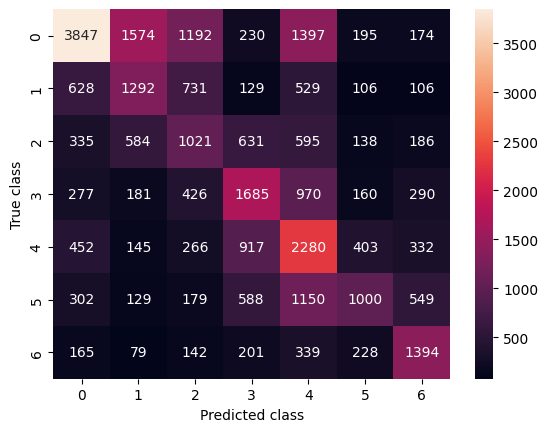

In [24]:
sns.heatmap(C, annot=True, fmt='.0f');
plt.gca().set_ylabel('True class')
plt.gca().set_xlabel('Predicted class');

In [25]:
acc = accuracy_score(valid_df['label'].values, valid_df['predicted_label'].values)
print(f'Accuracy score: {acc:.4f}')
print(f'MAP:            {np.diag(Cn).mean():.4f}')

Accuracy score: 0.4058
MAP:            0.4011


In [26]:
country_ids = valid_df['country_id'].unique()

plot_dfs = []

for country in country_ids:
    country_df = valid_df.loc[valid_df['country_id'] == country]
    cacc = accuracy_score(country_df['label'].values, country_df['predicted_label'].values)
    
    cmat = confusion_matrix(country_df['label'], country_df['predicted_label'], normalize='true').diagonal()
    
    plot_dfs.append(pd.DataFrame(dict(country=country, classes=list(range(7)), cmat=cmat)))
    
    
    print(f'Country ID: {country}, MCA = {cacc:.4f}, count = {len(country_df)}')

Country ID: PNN, MCA = 0.3382, count = 9989
Country ID: HUN, MCA = 0.1919, count = 2830
Country ID: QCD, MCA = 0.5379, count = 8368
Country ID: FMW, MCA = 0.4554, count = 7815
Country ID: EMA, MCA = 0.2944, count = 1583
Country ID: NEA, MCA = 0.2727, count = 264


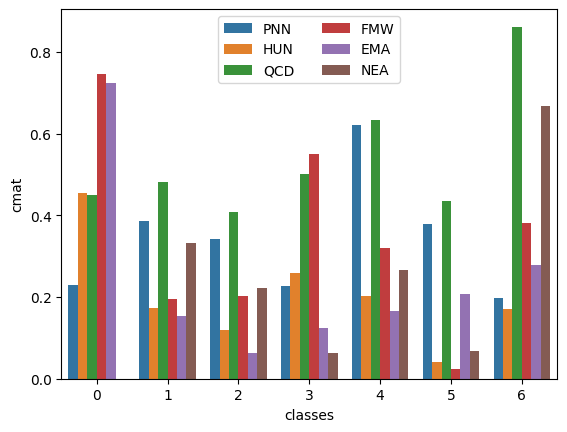

In [27]:
plot_df = pd.concat(plot_dfs)
sns.barplot(plot_df, x='classes', y='cmat', hue='country')
plt.gca().legend(ncol=2)
plt.show()

In [28]:
folds = valid_df['fold_y'].unique()
for fold in folds:
    country_df = valid_df.loc[valid_df['fold_y'] == fold]
    cacc = accuracy_score(country_df['label'].values, country_df['predicted_label'].values)
    
    print(f'Fold: {fold}, MCA = {cacc:.4f}, count = {len(country_df)}')

Fold: 0, MCA = 0.3412, count = 9168
Fold: 1, MCA = 0.4690, count = 7754
Fold: 2, MCA = 0.3739, count = 3276
Fold: 3, MCA = 0.4345, count = 5471
Fold: 4, MCA = 0.4154, count = 5180


## Inspect mis-classified samples

In [29]:
# Define paths to data

# input_path = "directory with MapYourCity image files"
input_path = "../data/AI4EO-MapYourCity/v1/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"

1574 samples were classified as 1 but are 0
             pid country_id city_id
8096  79annzhv4z        PNN   U8MZD


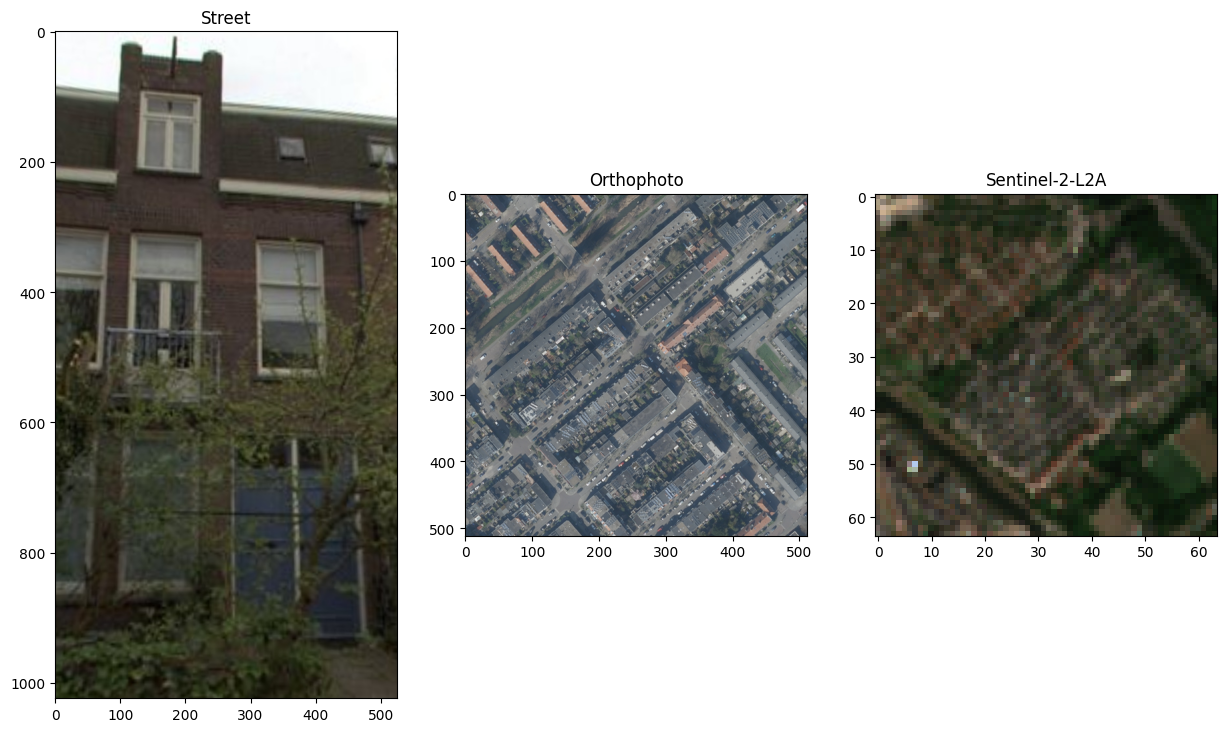

In [30]:
# Choose a building by pid:
tclass = 0
pclass = 1
mismatched_df = valid_df.query('label==@tclass and predicted_label==@pclass')
print(f'{len(mismatched_df)} samples were classified as {pclass} but are {tclass}')

pid = mismatched_df['pid'].iloc[np.random.randint(len(mismatched_df))]
print(valid_df.loc[valid_df['pid'] == pid][['pid', 'country_id', 'city_id']])
street = plt.imread(f"{train_path}{pid}/street.jpg")
orthophoto = plt.imread(f"{train_path}{pid}/orthophoto.tif")
s2 = rasterio.open(f"{train_path}{pid}/s2_l2a.tif").read()
s2 = np.transpose(s2,[1,2,0])

# Show the 3 modalities - street view, orthophoto and Seninel-2

fig, axs = plt.subplots(figsize=(15, 15), nrows=1, ncols = 3)
axs = axs.flatten()
axs[0].imshow(street)
axs[1].imshow(orthophoto)
axs[2].imshow(s2[...,[3,2,1]]*3e-4)

axs[0].set_title("Street")
axs[1].set_title("Orthophoto")
axs[2].set_title("Sentinel-2-L2A")

plt.show()

## Merge streetview

In [31]:
df1 = pd.read_csv('../submissions/topview_swin_04-19_A.csv').rename(columns={'predicted_label':'topview_label'})
df3 = pd.read_csv('../submissions/sentinel2_patch_swin_04-20_A.csv').rename(columns={'predicted_label':'sentinel2_label'})
df2 = pd.read_csv('../submissions/streetview_swin_04-19_A.csv').rename(columns={'predicted_label':'streetview_label'})
is_valid_streetview = pd.read_csv('valid_streetview.csv')
target = '../submissions/merged_topstreet_swin_04-19_A.csv'

In [32]:
df2 = df2[is_valid_streetview['is_valid_streetview']]

In [33]:
df = pd.merge(df3, pd.merge(df1, df2, 'outer'), 'outer')

In [34]:
predicted_label = []
for i in range(len(df)):
    if np.isnan(df.iloc[i]['streetview_label']) or \
               df.iloc[i]['topview_label'] == df.iloc[i]['streetview_label']:
        predicted_label.append(df.iloc[i]['topview_label'])
    else:
        predicted_label.append(df.iloc[i]['streetview_label'])
        

In [35]:
df['predicted_label'] = np.array(predicted_label).astype(int)
df = df.drop(columns=['topview_label', 'streetview_label'])
df.to_csv(target, index=False)

In [40]:
a = dict(b=3, c=4)

In [43]:
list(a.values())[0]

3